<center>
  <h1 style="background-color: #80dfffff; color: #137a91ff; padding: 10px">
    <strong>Model Development</strong>
  </h1>
</center>

**Student ID's:**

Andreea Roica: 20250361

Beatriz Varela: 20250367

Barbara Franco: 20250388

Marisa Esteves: 20250348

#
<h2 style="background-color: #80dfffff; color: #137a91ff; padding: 5px; margin: 5px;">
<strong>Index</strong>
</h2>


[1. **Pre Processing**](#1st-bullet)<br>

[2. **Pipeline**](#2nd-bullet)<br>

[3. **Fine Tuning**](#3rd-bullet)<br>

[4. **Model Comparison**](#9th-bullet)<br>

[5. **Ablation Study**](#10th-bullet)<br>

[6. **Feature Importance**](#11th-bullet)<br>
    

#
<h2 style="background-color: #80dfffff; color: #137a91ff; padding: 5px; margin: 5px;">
<strong>Imports</strong>
</h2>

Importing the necessary libraries:

In [19]:
from Classes import *

from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.compose import TransformedTargetRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer

from sklearn.pipeline import Pipeline

import seaborn as sns

import shap

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


Uploading the dataset:

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Setting carID as index:

In [4]:
df_train.set_index('carID', inplace=True)
df_test.set_index('carID', inplace=True)

Setting a seed:

In [5]:
random_state = 42

#
<h2 id="1st-bullet" style="background-color: #f7d888ff; color: #da6919ff; padding: 5px; margin: 5px;">
  <strong>  1. Pre Processing</strong>
</h2>


We start by defining the inconsistent values discussed in the EDA as NA:

In [6]:
df_train.loc[df_train['year']>2020, 'year'] = np.nan
df_test.loc[df_test['year']>2020, 'year'] = np.nan

df_train.loc[df_train['mileage']<0, 'mileage'] = np.nan
df_test.loc[df_test['mileage']<0, 'mileage'] = np.nan

df_train.loc[df_train['tax']<0, 'tax'] = np.nan
df_test.loc[df_test['tax']<0,'tax'] = np.nan

df_train.loc[df_train['mpg']<=0, 'mpg'] = np.nan
df_test.loc[df_test['mpg']<=0, 'mpg'] = np.nan

df_train.loc[df_train['paintQuality%']>100, 'paintQuality%'] = np.nan
df_test.loc[df_test['paintQuality%']>100, 'paintQuality%'] = np.nan

df_train.loc[df_train['previousOwners']< 0, 'previousOwners'] = np.nan
df_test.loc[df_test['previousOwners']< 0, 'previousOwners'] = np.nan

df_train.loc[df_train['engineSize']<= 0, 'engineSize'] = np.nan
df_test.loc[df_test['engineSize']<= 0, 'engineSize'] = np.nan

df_train.loc[df_train['mpg'] < 40, 'mpg'] = np.nan
df_train.loc[df_train['engineSize'] < 1, 'engineSize'] = np.nan

df_test.loc[df_test['mpg'] < 40, 'mpg'] = np.nan
df_test.loc[df_test['engineSize'] < 1, 'engineSize'] = np.nan

We proceed to round 'year' and 'previousOwners' to whole numbers using the floor function. Other numerical features are rounded to 2 decimal points.

In [7]:
df_train['year'] = np.floor(df_train['year'])
df_train['previousOwners'] = np.floor(df_train['previousOwners'])

df_test['year'] = np.floor(df_test['year'])
df_test['previousOwners'] = np.floor(df_test['previousOwners'])

for feat in ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%']:
    df_train[feat] = df_train[feat].round(2)
    df_test[feat] = df_test[feat].round(2)

We also pre-process the categorical variables in order to have a uniform format for later treatment (inside k-fold CV). We remove leeading and trailing spaces and uppercase all letters.

In [8]:
# Pre processing the categorical variables to be easier to find clusters in typos:
    # remove spaces (at the beginning and end) and uppercase all letters
    # does not replace NaN's
df_train['Brand'] = df_train['Brand'].where(df_train['Brand'].isna(), df_train['Brand'].astype(str).str.strip().str.upper())
df_test['Brand']  = df_test['Brand'].where(df_test['Brand'].isna(), df_test['Brand'].astype(str).str.strip().str.upper())

df_train['model'] = df_train['model'].where(df_train['model'].isna(), df_train['model'].astype(str).str.strip().str.upper())
df_test['model']  = df_test['model'].where(df_test['model'].isna(), df_test['model'].astype(str).str.strip().str.upper())

df_train['fuelType'] = df_train['fuelType'].where(df_train['fuelType'].isna(), df_train['fuelType'].astype(str).str.strip().str.upper())
df_test['fuelType']  = df_test['fuelType'].where(df_test['fuelType'].isna(), df_test['fuelType'].astype(str).str.strip().str.upper())

df_train['transmission'] = df_train['transmission'].where(df_train['transmission'].isna(), df_train['transmission'].astype(str).str.strip().str.upper())
df_test['transmission']  = df_test['transmission'].where(df_test['transmission'].isna(), df_test['transmission'].astype(str).str.strip().str.upper())


Drop informations given by the mechanic: 

In [9]:
df_train.drop ('paintQuality%', axis =1 , inplace =True)
df_test.drop ('paintQuality%', axis =1 , inplace =True)

The W's in brand could either mean 'BMW' or 'VW'. We already checked that they are all 'VW', so lets correct the W's:

In [10]:
df_train.loc[df_train['Brand'] == 'W', 'Brand'] = 'VW'
df_test.loc[df_test['Brand'] == 'W', 'Brand'] = 'VW'

Division between input variables (X) and output variable (y):

In [11]:

y = df_train['price']
X = df_train.drop('price', axis=1)


#
<h2 id="2nd-bullet" style="background-color: #f7d888ff; color: #da6919ff; padding: 5px; margin: 5px;">
  <strong>  2. Pipeline</strong>
</h2>


We are going to build a pipeline that is shared by all the models.

This funtion is created here because it uses the classes, therefore it cannot be include in the functions.py file like the others.

In [15]:
def build_pipeline(regressor, use_log=True, scaler_instance=None):

    """
    Builds a complete machine learning pipeline for regression tasks. 
    The pipeline allows different regressors, scaling strategies and optional log-transformation of the target variable.

    Parameters
    ----------
    regressor: 
        Regression model used as the final estimator.

    use_log: boolean 
        Indicates whether to apply log-transformation to the target variable.

    scaler_instance: scaler object 
        Scaler object passed to the scaling step.

    Returns
    -------
    sklearn.pipeline.Pipeline
        A machine learning pipeline with preprocessing, feature engineering, feature selection, and regression steps.
    """

    if use_log:
        final_reg = TransformedTargetRegressor(regressor=regressor,
                                               func=np.log,
                                               inverse_func=np.exp)
    else:
        final_reg = regressor

    return Pipeline([
        ('categorical_treatment', Categorical_Correction()),
        ('outlier_treatment', Outlier_Treatment()),
        ('missing_value_treatment', Missing_Value_Treatment()),
        ('typecasting', Typecasting()),
        ('feature_engineering', Feature_Engineering()),
        ('encoder', Encoder()),
        ('scaler', Scaler(scaler=scaler_instance)),
        ('feature_selection', Feature_Selection()),
        ('regressor', final_reg)
    ])

#
<h2 id="3rd-bullet" style="background-color: #f7d888ff; color: #da6919ff; padding: 5px; margin: 5px;">
  <strong>  3. Fine Tuning</strong>
</h2>


We are going to create a model dictionary that defines the regressor instance and the hyperparameter search space.

In [ ]:
models_testing = {
    "KNN": {
        "regressor": KNeighborsRegressor(),
        "use_log": True,
        "param_distributions": {
            'feature_selection__rfe_k': list(range(1,15)),
            'feature_selection__spearman_thr': [0.2, 0.25, 0.3],
            'regressor__regressor__n_neighbors': np.arange(1, 100),
            'regressor__regressor__weights': ['uniform', 'distance'],
            'regressor__regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'regressor__regressor__metric': ['minkowski', 'manhattan', 'euclidean', 'chebyshev'],
            'regressor__regressor__p': [1, 1.5, 2, 3, 4],
            'scaler__scaler': [StandardScaler(), MinMaxScaler(feature_range=(0,1)), MinMaxScaler(feature_range=(-1,1)), RobustScaler()]
        }
    },

    "GradientBoosting": {
        "regressor": GradientBoostingRegressor(),
        "use_log": True,
        "param_distributions": {
            'feature_selection__rfe_k': list(range(1,15)),
            'feature_selection__spearman_thr': [0.2, 0.25, 0.3],
            'regressor__regressor__max_features': [0.4, 0.5, 0.6],
            'regressor__regressor__loss': ['absolute_error', 'huber'],
            'regressor__regressor__n_estimators': [700, 900, 1100],
            'regressor__regressor__max_depth': [6, 7, 8, 9], 
            'regressor__regressor__learning_rate': [0.02, 0.03, 0.04, 0.05],
            'regressor__regressor__subsample': [0.75, 0.8],
            'regressor__regressor__min_samples_split': [4, 5, 6],
            'regressor__regressor__min_samples_leaf': [3, 4],
            'regressor__regressor__criterion': ['squared_error'],
            'regressor__regressor__min_impurity_decrease': [0.0, 0.0001, 0.0005],
            'regressor__regressor__max_leaf_nodes': [None, 30, 40],
            'regressor__regressor__n_iter_no_change': [None, 10, 15],
            'regressor__regressor__validation_fraction': [0.15, 0.2],
            'scaler__scaler': [StandardScaler(), MinMaxScaler(feature_range=(0,1)), MinMaxScaler(feature_range=(-1,1)), RobustScaler()]
        }
    },

    "RandomForest": {
        "regressor": RandomForestRegressor(),
        "use_log": False,
        "param_distributions": {
            'feature_selection__rfe_k': list(range(1,15)),
            'feature_selection__spearman_thr': [0.2, 0.25, 0.3],
            'regressor__n_estimators': [400],
            'regressor__min_samples_split': [24,25,26,30,35],  
            'regressor__min_samples_leaf': [2,3,4],   
            'regressor__max_features': [0.5],
            'regressor__max_depth': [18,19,20],         
            'regressor__min_impurity_decrease': [0.001],
            'regressor__ccp_alpha':[0.00005, 0.0001],
            'regressor__max_samples': [0.75],
            'regressor__criterion': ['squared_error'], #default
            'regressor__bootstrap': [True], #default
            'scaler__scaler': [StandardScaler(), MinMaxScaler(feature_range=(0,1)), MinMaxScaler(feature_range=(-1,1)), RobustScaler()]
        }
    }

}

### Randomized Search

This funtion is created here because it uses build_pipeline, therefore it cannot be include in the functions.py file like the others.

In [17]:
def run_model_search(name, cfg, X, y, n_iter=2, cv=5, random_state=42):

    """
    Runs a RandomizedSearchCV for hyperparameter tuning of a regression model pipeline.

    Parameters
    ----------
    name : str
        The name of the model being evaluated.

    cfg : dict
        Configuration dictionary containing:    
        - 'regressor': The regression model to be used in the pipeline. 
        - 'use_log': Boolean indicating whether to apply log transformation to the target variable.
        - 'param_distributions': Dictionary of hyperparameter distributions for RandomizedSearchCV.
    
    X : pandas.DataFrame
        Feature matrix used for training the model.

    y : pandas.Series
        Target variable (price).

    n_iter : int, default=2
        Number of parameter settings that are sampled in RandomizedSearchCV.

    cv : int, default=5
        Number of cross-validation folds.

    random_state : int, default=42
        Random seed for reproducibility.

    Returns
    -------
    dict
        A dictionary containing:
        - 'Model': The name of the model.
        - 'Use_Log': Boolean indicating if log transformation was used.
        - 'Search_Object': The fitted RandomizedSearchCV object.
        - 'CV_Results': DataFrame with cross-validation results and additional metrics.

    """
    scoring = { 'R2': 'r2', 
    'MAE': 'neg_mean_absolute_error',
    'MAPE': 'neg_mean_absolute_percentage_error',
    'MedAE': 'neg_median_absolute_error',
    'RMSE': 'neg_root_mean_squared_error'}

    print(f"\n=== Running: {name} (use_log={cfg['use_log']}) ===")

    pipeline = build_pipeline(cfg['regressor'], use_log=cfg['use_log'])
    params = cfg['param_distributions']
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params,
        n_iter=n_iter,
        scoring=scoring,
        refit='MAE',
        cv=KFold(n_splits=cv, shuffle=True, random_state=random_state),
        verbose=2,
        return_train_score=True,
        random_state=random_state,
        n_jobs=-1
    )
    t0 = time.time()
    search.fit(X, y)
    t_elapsed = time.time() - t0

    cv_results_df = pd.DataFrame(search.cv_results_)
    
    cv_results_df['overfit_mae'] = cv_results_df['mean_test_MAE'] / cv_results_df['mean_train_MAE']
    cv_results_df['overfit_R2'] = cv_results_df['mean_train_R2'] - cv_results_df['mean_test_R2']
    cv_results_df['Model'] = name
    cv_results_df['Use_Log'] = cfg['use_log']
    cv_results_df['Execution_Time_s'] = t_elapsed

    result = {
        'Model': name,
        'Use_Log': cfg['use_log'],
        'Search_Object': search,
        'CV_Results': cv_results_df
    }
    return result

### Loop through all models

After collecting all CV results from every model, we are going to rank all hyperparameter combinations by lowest test MAE and display the top 50 best-performing configurations.

In [ ]:
all_results = []
for model_name, cfg in models_testing.items():
    res = run_model_search(model_name, cfg, X, y, n_iter=2, cv=5, random_state=random_state)
    all_results.append(res)

all_cv_summary = pd.concat([r['CV_Results'] for r in all_results], ignore_index=True)

all_cv_summary['mean_train_MAE_pos'] = -all_cv_summary['mean_train_MAE']
all_cv_summary['mean_test_MAE_pos'] = -all_cv_summary['mean_test_MAE']

top_50_cv_summary = all_cv_summary.sort_values('mean_test_MAE_pos', ascending=True).head(50)

print("=== Top 50 hyperparameter combinations with lowest CV MAE ===")
display(top_50_cv_summary[[
    'Model', 'Use_Log', 'params',
    'mean_train_MAE_pos', 'mean_test_MAE_pos',
    'mean_train_R2', 'mean_test_R2',
    'mean_train_MAPE', 'mean_test_MAPE',
    'mean_train_MedAE', 'mean_test_MedAE',
    'mean_train_RMSE', 'mean_test_RMSE',
    'overfit_mae', 'overfit_R2'
]])



=== Running: KNN (use_log=True) ===
Fitting 5 folds for each of 2 candidates, totalling 10 fits

=== Running: GradientBoosting (use_log=False) ===
Fitting 5 folds for each of 2 candidates, totalling 10 fits
=== Top 50 hyperparameter combinations with lowest CV MAE ===


,Model,Use_Log,params,mean_train_MAE_pos,mean_test_MAE_pos,mean_train_R2,mean_test_R2,mean_train_MAPE,mean_test_MAPE,mean_train_MedAE,mean_test_MedAE,mean_train_RMSE,mean_test_RMSE,overfit_mae,overfit_R2
2,GradientBoosting,False,{'scaler__scaler': MinMaxScaler(feature_range=...,1473.837889,1556.191829,0.925425,0.914128,-0.091466,-0.095356,-9.422962e+02,-973.513016,-2658.812696,-2852.072548,1.055877,0.011297
0,KNN,True,{'scaler__scaler': MinMaxScaler(feature_range=...,114.819159,1660.536907,0.994634,0.888085,-0.008928,-0.100693,-7.275958e-12,-957.212427,-710.484054,-3253.954286,14.462194,0.106549
1,KNN,True,"{'scaler__scaler': StandardScaler(), 'regresso...",114.817839,1673.739072,0.994634,0.885157,-0.008927,-0.100571,-7.275958e-12,-965.484261,-710.476463,-3296.375745,14.577343,0.109477
3,GradientBoosting,False,"{'scaler__scaler': RobustScaler(), 'regressor_...",3658.482504,3667.585444,0.730164,0.727205,-0.264911,-0.265634,-2.746962e+03,-2752.301207,-5057.368631,-5083.715376,1.002488,0.002960


#
<h2 id="4th-bullet" style="background-color: #f7d888ff; color: #da6919ff; padding: 5px; margin: 5px;">
  <strong>  4. Model Comparison</strong>
</h2>

Fazer talvez uma tabela com os melhores resultados de cada modelo? Analisar em comparação com os melhores MAE'S que temos

### **Conclusions**

justificar a escolhar e a seguir apresentar quais os escolhidos

The best parameters are:

In [20]:
print(all_cv_summary['params'][0]) #depois mudar de 0 para o indice certo!!

{'scaler__scaler': MinMaxScaler(feature_range=(-1, 1)), 'regressor__regressor__weights': 'distance', 'regressor__regressor__p': 3, 'regressor__regressor__n_neighbors': np.int64(38), 'regressor__regressor__metric': 'minkowski', 'regressor__regressor__algorithm': 'auto', 'feature_selection__spearman_thr': 0.3, 'feature_selection__rfe_k': 12}


#
<h2 id="5th-bullet" style="background-color: #f7d888ff; color: #da6919ff; padding: 5px; margin: 5px;">
  <strong>  5. Ablation Study</strong>
</h2>


For the ablation study, we'll evaluate the performance of the chosen model with the best parameters removing or simplifying (when removing is not possible) one step of the pipeline at a time. We'll compare these results with the performance of the model using the full pipeline.

Defining the CV strategy and the scoring metrics:

In [ ]:
CV = KFold(n_splits=2, shuffle=True, random_state=42)  
scoring = { 'R2': 'r2', 'MAE': 'neg_mean_absolute_error'}

Defining the full pipeline and saving the results:

In [ ]:
pipeline = Pipeline([
    ('categorical treatment', Categorical_Correction()),  
    ('outlier treatment', Outlier_Treatment()),                   
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()), 
    ('feature engineering', Feature_Engineering()), 
    ('encoder', Encoder() ), 
    ('scaler', Scaler()), 
    ('feature selection', Feature_Selection()),
    ('regressor', LinearRegression() ) # corrigir para o regressor final!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
])

In [ ]:
# Full Pipeline with the Final Regressor
baseline_train_r2, baseline_test_r2, baseline_train_mae, baseline_test_mae, baseline_time = evaluate(pipeline, X, y, cv=CV, scoring=scoring)
baseline_pipeline_results = {
    'Step Tested': 'Full Pipeline',
    'Train R2': baseline_train_r2,
    'Test R2': baseline_test_r2,
    'Train MAE': baseline_train_mae,
    'Test MAE': baseline_test_mae,
    'Execution Time': baseline_time }

Testing each step individually:

In [ ]:
steps_to_test = ['categorical treatment','outlier treatment','missing value treatment','typecasting', 'feature engineering','encoder','scaler','feature selection']

results = []

results.append (baseline_pipeline_results)

for step in steps_to_test:

    simplified_pipeline = Pipeline([
        ('categorical treatment', Categorical_Correction() if step != 'categorical treatment' else Simplified_Categorical_Correction()),
        ('outlier treatment', Outlier_Treatment() if step != 'outlier treatment' else Identity_Transformer()),                   
        ('missing value treatment', Missing_Value_Treatment() if step != 'missing value treatment' else Simplified_Missing_Value_Treatment()),
        ('typecasting', Typecasting() if step != 'typecasting' else Identity_Transformer()), 
        ('feature engineering', Feature_Engineering() if step != 'feature engineering' else Identity_Transformer()), 
        ('encoder', Encoder() if step != 'encoder' else Simplified_Encode()), 
        ('scaler', Scaler() if step != 'scaler' else Identity_Transformer()), 
        ('feature selection', Feature_Selection() if step != 'feature selection' else Identity_Transformer()),
        ('regressor', LinearRegression() )
    ])
    
    train_r2, test_r2, train_mae, test_mae, exec_time = evaluate(simplified_pipeline, X, y, cv=CV, scoring=scoring)
    
    results.append({
        'Step Tested': step,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Execution Time': exec_time
    })

Exception ignored in: <function ResourceTracker.__del__ at 0x103a51bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1073e9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Finally, concatenate all results:

In [39]:
results = pd.DataFrame(results)

results ['Overfit_Mae'] = results ['Test MAE'] / results ['Train MAE']

results ['Delta'] = results ['Test MAE'] - results ['Test MAE'][0] 

results

,Step Tested,Train R2,Test R2,Train MAE,Test MAE,Execution Time,Overfit_Mae,Delta
0,Full Pipeline,0.804019,0.801933,2645.460038,2653.268049,2.184193,1.002951,0.000000
1,categorical treatment,0.800903,0.797610,2680.238427,2695.125387,1.977655,1.005554,41.857338
2,outlier treatment,0.816300,0.814293,2606.386399,2614.775887,2.147849,1.003219,-38.492163
3,missing value treatment,0.797076,0.795157,2682.526066,2690.458376,0.738717,1.002957,37.190327
4,typecasting,0.804019,0.801933,2645.460038,2653.268049,2.155385,1.002951,0.000000
5,feature engineering,0.803437,0.801439,2658.626047,2666.118452,2.052179,1.002818,12.850403
6,encoder,0.725060,0.723685,3287.661716,3288.903515,27.132786,1.000378,635.635466
7,scaler,0.803531,0.801417,2654.327940,2662.161298,2.210716,1.002951,8.893249
8,feature selection,0.805097,0.802970,2627.974506,2636.058472,1.969496,1.003076,-17.209577


### **Conclusions** 


BLABLABLABALABALABALA

#
<h2 id="6th-bullet" style="background-color: #f7d888ff; color: #da6919ff; padding: 5px; margin: 5px;">
  <strong>  6. Feature Importance</strong>
</h2>

We will now explore the importance of each feature for the final prediction. For this, we will use our best model and the same pipeline, while skipping the feature selection step. We will fit the whole train dataset into said pipeline and use the feature_importances_ attribute from GradientBoostingRegressor as to obtain feature importance values. Corresponding feature names will be obtained from the last transformer's feats_names_ attribute which was defined within the scaler class.

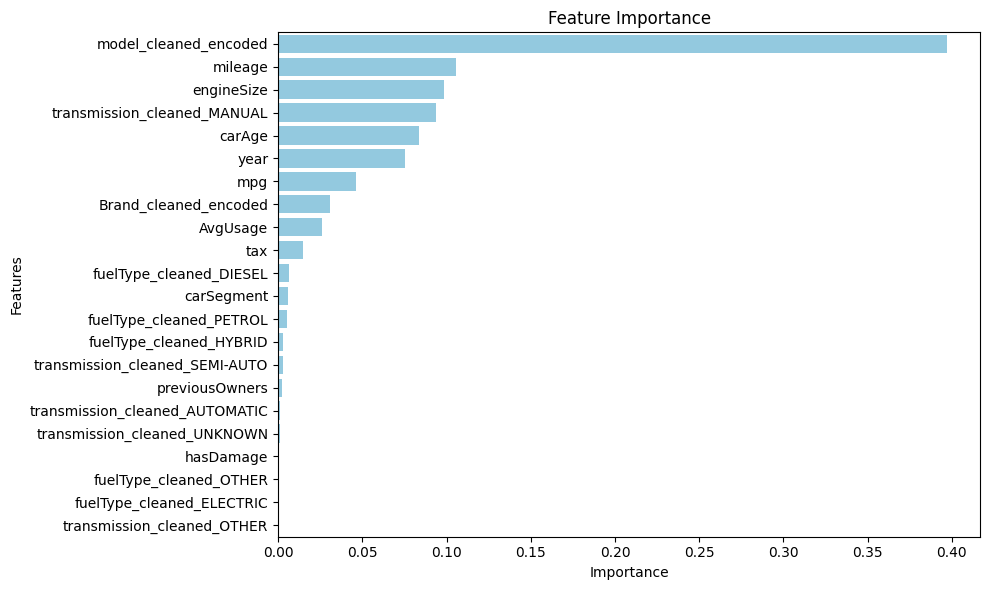

In [12]:
# best model parameters (w/ gradient boost) MUDAR
params = {'regressor__validation_fraction': 0.15, 'regressor__subsample': 0.8, 'regressor__n_iter_no_change': None, 'regressor__n_estimators': 900, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 4, 'regressor__min_impurity_decrease': 0.0, 'regressor__max_leaf_nodes': 40, 'regressor__max_features': 0.6, 'regressor__max_depth': 7, 'regressor__loss': 'absolute_error', 'regressor__learning_rate': 0.04, 'regressor__criterion': 'squared_error'}

# pipeline
importance_pipeline = Pipeline([
    ('categorical treatment', Categorical_Correction()),  
    ('outlier treatment', Outlier_Treatment()),                   
    ('missing value treatment', Missing_Value_Treatment()),
    ('typecasting', Typecasting()), 
    ('feature engineering', Feature_Engineering()), 
    ('encoder', Encoder() ), 
    ('scaler', Scaler(scaler=RobustScaler())), # MUDAR scaler
    ('regressor', GradientBoostingRegressor())
])

importance_pipeline = importance_pipeline.set_params(**params)
importance_pipeline = importance_pipeline.fit(X,y)

feature_importance = importance_pipeline.named_steps['regressor'].feature_importances_ 
feature_names = importance_pipeline.named_steps['scaler'].feats_names_

# creating a dataframe of features and corresponding importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# sorting the dataframe by importance in descending order for clearer visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False) 
# visualizing importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], color="skyblue")
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

Feature importance values given by GradientBoosterRegressor completar (...)

We will now obtain SHAP values for each feature in order to see how it affects predictions (how much and in which direction).

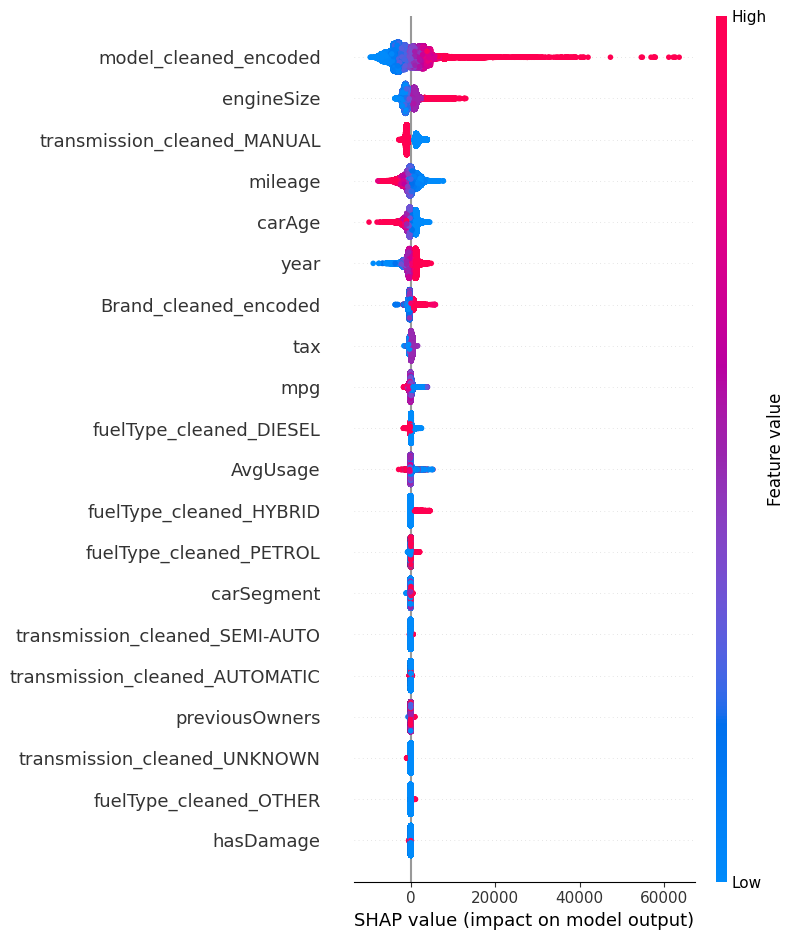

In [ ]:
#np.bool = bool

# getting the previous pipeline without the last step, i.e. keeping the transformers and excluding the regressor
preprocessor = Pipeline(importance_pipeline.steps[:-1])

# applying the new pipeline to train set to get pre-processed data
X_processed = preprocessor.transform(X)

# creating a shap TreeExplainer for the regressor
explainer = shap.TreeExplainer(importance_pipeline.named_steps['regressor'])

# getting shap values by passing processed data into the explainer
shap_values = explainer.shap_values(X_processed)

shap.summary_plot(shap_values, X_processed)

In [30]:
y_labels = ['low', 'medium-low', 'medium-high', 'high']
y_bins, bin_edges = pd.cut(y, bins=4, labels=y_labels, retbins=True)
bin_edges 

array([   290.451,  40337.25 ,  80224.5  , 120111.75 , 159999.   ])

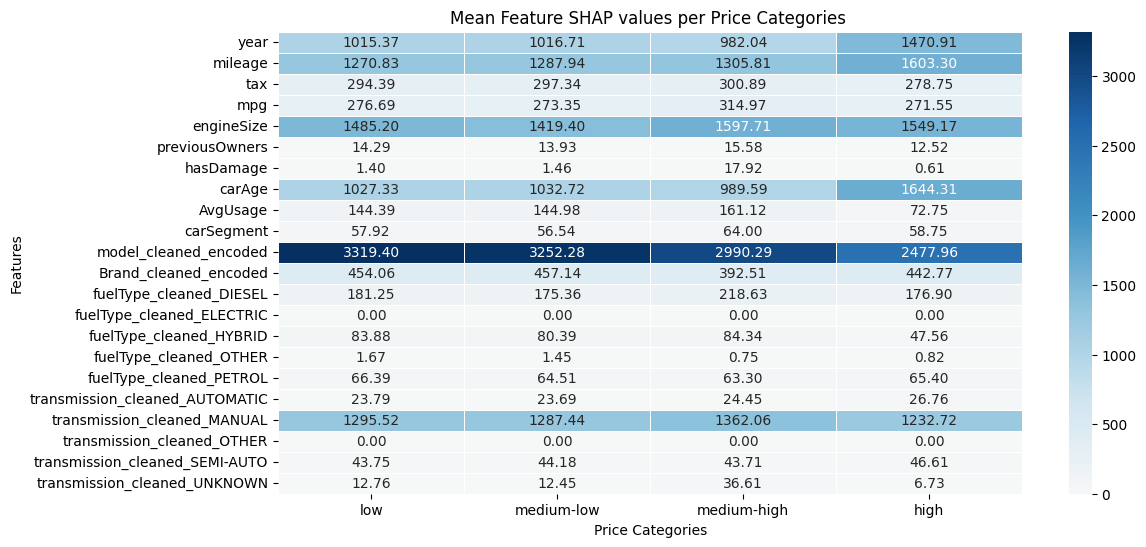

In [33]:

# converting shap values with features to dataframe for convenience
shap_df = pd.DataFrame(shap_values, columns=feature_names)

# computing absolute mean shap value for each feature in each bin
mean_shap_per_bin = shap_df.abs().groupby(y_bins).mean()

# heatmap for visualization
plt.figure(figsize=(12,6))
sns.heatmap(mean_shap_per_bin.T, cmap="RdBu", annot=True, fmt=".2f", linewidths=0.5, cbar=True, center=0)
plt.xlabel("Price Categories")
plt.ylabel("Features")
plt.title("Mean Feature SHAP values per Price Categories ")
plt.show()


### **Conclusions**